In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp
from sklearn_pandas import DataFrameMapper
from sklearn_pandas import CategoricalImputer
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing.imputation  import Imputer
from sklearn.preprocessing  import StandardScaler,LabelBinarizer
from sklearn.metrics import roc_curve, auc, f1_score,classification_report,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin




%matplotlib inline

df = pd.read_parquet("/home/adam/bigdata/dane/codereview/stack_table.parquet")

df = df.drop(['UserLocation','AcceptedAnswerId','CreationDate','OwnerUserId','Body','Title','codesnippet','Tags','body_cleaned','Spam','Off'],axis=1)  
df['no_sentences_body'] = df['no_sentences_body'].astype('int')
df['no_words_body'] = df['no_words_body'].astype('int')
df['no_signs_body'] = df['no_signs_body'].astype('int')
df['no_digits_body'] = df['no_digits_body'].astype('int')
df['pct_answers_to_questions'] = df['No_of_answers'] / df['No_of_questions']
df['pct_no_of_questions_last_year'] = df['No_of_questions_last_year'] / df['No_of_questions']
df['pct_class1'] = df['class1'] / df[['class1', 'class2','class3']].sum(axis=1)
df['pct_class2'] = df['class2'] / df[['class1', 'class2','class3']].sum(axis=1)
df['pct_class3'] = df['class3'] / df[['class1', 'class2','class3']].sum(axis=1)

# df['YN_no_of_questions'] = 'Unknown'
# df.loc[(df.No_of_questions_last_year==0) & (df.No_of_questions==0), 'YN_no_of_questions'] = 'NN'
# df.loc[(df.No_of_questions_last_year==0) & (df.No_of_questions>0), 'YN_no_of_questions'] = 'NY'
# df.loc[(df.No_of_questions_last_year==0) & (df.No_of_questions==0), 'YN_no_of_questions'] = 'YN'
# df.loc[(df.No_of_questions_last_year>0) & (df.No_of_questions>0), 'YN_no_of_questions'] = 'YY'


df['Flag_'+'Time_from_last_question'+'_missing'] = df['Time_from_last_question'].isnull().astype('int')
df[['Flag_Location','Flag_AboutMe','Flag_WebsiteUrl','Time_from_last_question', 'pct_class3','pct_class2','pct_class1']] = df[['Flag_Location','Flag_AboutMe','Flag_WebsiteUrl','Time_from_last_question', 'pct_class3','pct_class2','pct_class1']].fillna(value=0)
df.loc[~df.UserContinent.isin(['Brak','EU','NA','SA','AS','OC','AF']),'UserContinent'] = np.nan
#df.set_index('Id',inplace=True)
df.info()
df[['pct_class3','class3','class2','class1']].head(60)
#df.columns



X = df[df.columns.difference(['Target'])]
y = df['Target']
#cols1 = df.columns.difference(['Target']).tolist() + ['Target']
# print(y.columns)
# print(X.columns)
#df = df[cols1]
#df.info()
#cols = cols1.append('Target')
#print(cols)
#X = df.iloc[:,:-1]
#y = df.iloc[:,-1]
#non_categorical_columns = ['Id','No_of_answers','No_of_comments','class1', 'class2','no_of_tags']  
#X = df[non_categorical_columns]
#y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size=0.3, random_state=123)
df_train = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([X_test,y_test],axis=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(df_train['Target'].value_counts())
print(df_test['Target'].value_counts())


/home/adam/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/adam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55105 entries, 0 to 55104
Data columns (total 47 columns):
Id                                      55105 non-null int32
Reputation                              54088 non-null float64
UserCountry                             55105 non-null object
UserAlpha2                              23789 non-null object
UserContinent                           53097 non-null object
Flag_Location                           55105 non-null float64
Flag_AboutMe                            55105 non-null float64
Flag_WebsiteUrl                         55105 non-null float64
Seniority                               54088 non-null float64
OwnerUserId_Null                        55105 non-null int32
Time_from_last_question                 55105 non-null float64
No_of_questions_last_year               55105 non-null int64
No_of_questions                         55105 non-null int32
word_count_title                        55105 non-null int32
word_count_body       

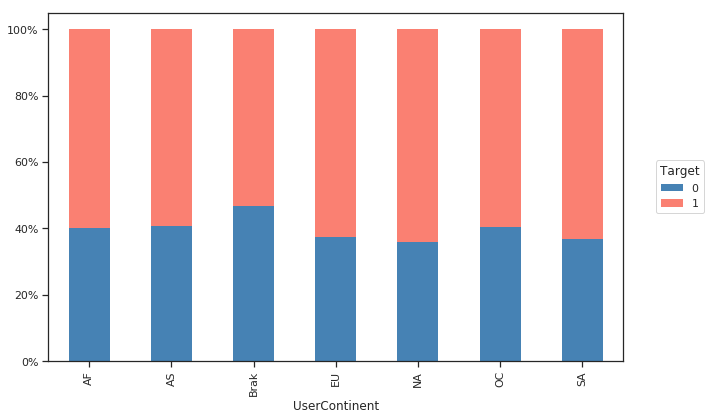

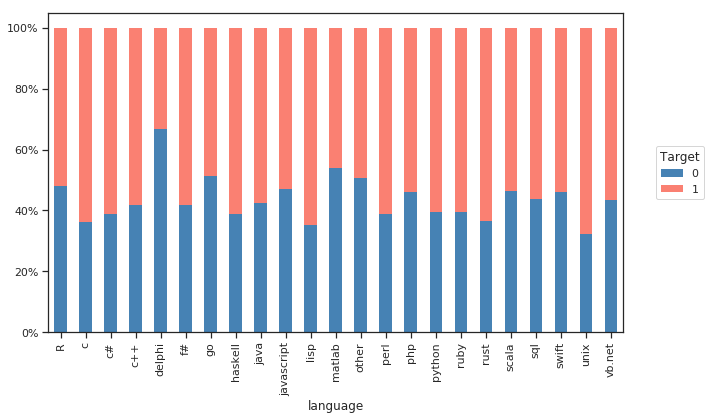

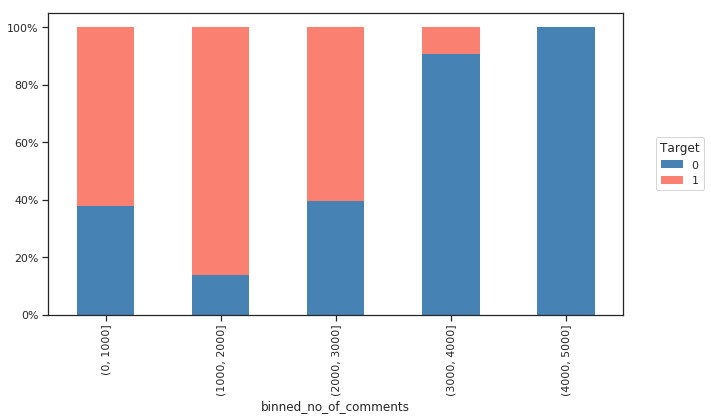

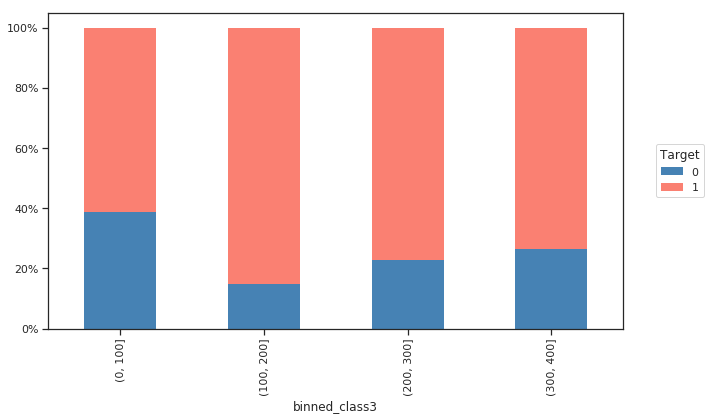

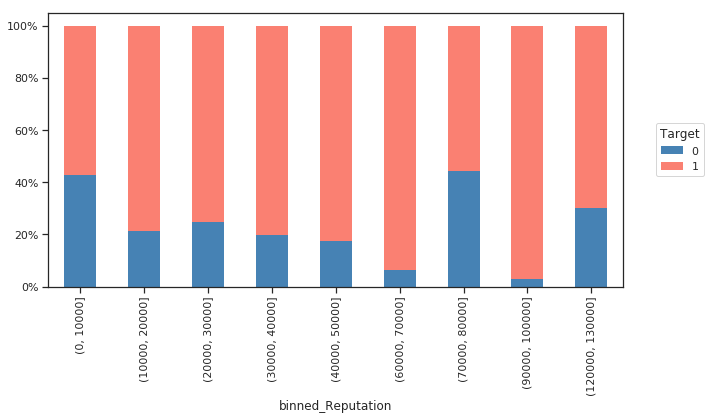

In [3]:
sns.set(style="ticks")
#g = sns.catplot(y="Target", kind="count", data=df, height=2.6, aspect=2.5, orient='h')
#g1 = sns.catplot(y="Flag_AboutMe", kind="count", data=df, height=2.6, aspect=2.5, orient='h')
#g1 = dxp.aggplot(agg='language', data=df, hue='Target', stacked=True, normalize='language',orient='h')
df_train['No_of_comments2'] = pd.cut(df_train['No_of_comments'], range(0, 6000, 500))
#df['No_of_comments2'].head()
#df['Flag_AboutMe'] = df['Flag_AboutMe'].astype('str')
#g2 = dxp.aggplot(agg='Flag_AboutMe', data=df, hue='Target', stacked=True, normalize='Flag_AboutMe')
#g2 = dxp.aggplot(agg='No_of_comments2', data=df, hue='Target', stacked=True, normalize='No_of_comments2',orient='h',figsize=(8, 4))

#g2 = dxp.aggplot(agg='language', data=df, hue='Target', stacked=True, normalize='language',orient='h',figsize=(8, 5))
palette = sns.color_palette(palette = ["SteelBlue" , "Salmon"])
#g2 = dxp.aggplot(agg='UserContinent', data=df, hue='Target',stacked=True, normalize='UserContinent',orient='h',figsize=(8, 5))
#g2.legend(loc='upper center')
#g2.set(palette=palette)
#plt.set_color_cycle(palette)
plt.tight_layout()
plt.show()
#dxp.aggplot?

# tps = df.pivot_table(values='Id',
#                       index='UserContinent',
#                       columns='Target',
#                       aggfunc='count')

# tps = tps.div(tps.sum(1), axis=0)*100
# tps.head()
#sns.barplot(tps,stacked=True)
#tps.plot(kind='bar', stacked=True,color = palette)
def barplot_stacked_percentages(feature, orient='v', axis_name="percentage of customers"):
    tps = df_train.pivot_table(values='Id',index=feature,columns='Target',aggfunc='count')
    tps = tps.div(tps.sum(1), axis=0)
    if orient == 'v':
        ax = tps.plot(kind='bar', stacked=True,color = palette, linewidth=0)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
        ax.legend(loc='center right', bbox_to_anchor=(1.15, 0.5), title="Target")
    else:
        ax = tps.plot(kind='barh', stacked=True,color = palette, linewidth=0)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
        ax.legend(loc='center right', bbox_to_anchor=(1.15, 0.5), title="Target")
    plt.gcf().set_size_inches(9, 6)
    
    
barplot_stacked_percentages("UserContinent")
plt.tight_layout()
plt.savefig("/home/adam/bigdata/dane/codereview/Target_continent_100.png",bbox_inches="tight")
barplot_stacked_percentages("language")
plt.tight_layout()
plt.savefig("/home/adam/bigdata/dane/codereview/Target_language_100.png",bbox_inches="tight")
df_train['binned_no_of_comments'] = pd.cut(df_train['No_of_comments'], range(0, 6000, 1000))
barplot_stacked_percentages("binned_no_of_comments")
plt.tight_layout()
plt.savefig("/home/adam/bigdata/dane/codereview/Target_no_comments_100.png",bbox_inches="tight")
df_train['binned_class3'] = pd.cut(df['class3'], range(0, 500, 100))
barplot_stacked_percentages("binned_class3")
plt.tight_layout()
plt.savefig("/home/adam/bigdata/dane/codereview/Target_class3_100.png",bbox_inches="tight")
# plt.tight_layout()
# plt.show()
df_train['binned_Reputation'] = pd.cut(df['Reputation'], range(0, 160000, 10000))
barplot_stacked_percentages("binned_Reputation")
plt.tight_layout()
plt.savefig("/home/adam/bigdata/dane/codereview/Target_Reputation_100.png",bbox_inches="tight")

/home/adam/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


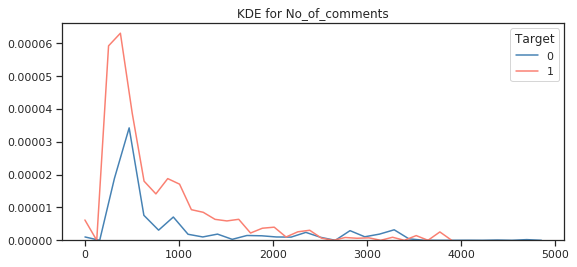

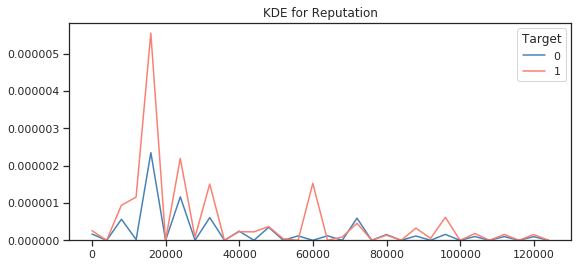

In [7]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Target'] == 0][feature].dropna(), color= 'SteelBlue', label= '0', gridsize = 20)
    ax1 = sns.kdeplot(df[df['Target'] == 1][feature].dropna(), color= 'Salmon', label= '1', gridsize = 20)
    ax0.legend(title="Target")
kdeplot('No_of_comments')
plt.savefig("/home/adam/bigdata/dane/codereview/kde_no_of_comments_100.png",bbox_inches="tight")
kdeplot('Reputation')
plt.savefig("/home/adam/bigdata/dane/codereview/kde_Reputation_100.png",bbox_inches="tight")




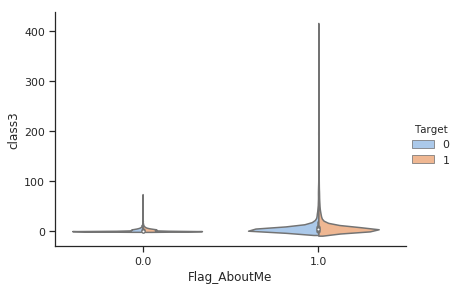

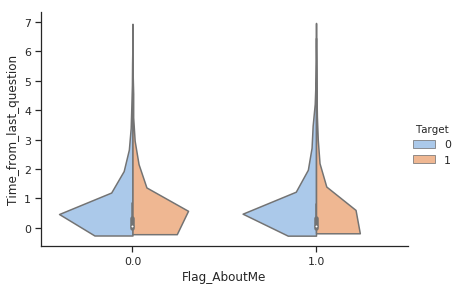

In [67]:
ax = sns.catplot(x="Flag_AboutMe", y="class3", hue="Target", kind="violin",
                 split=True, palette="pastel", data=df, height=4.2, aspect=1.4)

ax = sns.catplot(x="Flag_AboutMe", y="Time_from_last_question", hue="Target", kind="violin",
                 split=True, palette="pastel", data=df, height=4.2, aspect=1.4 ,gridsize = 10)

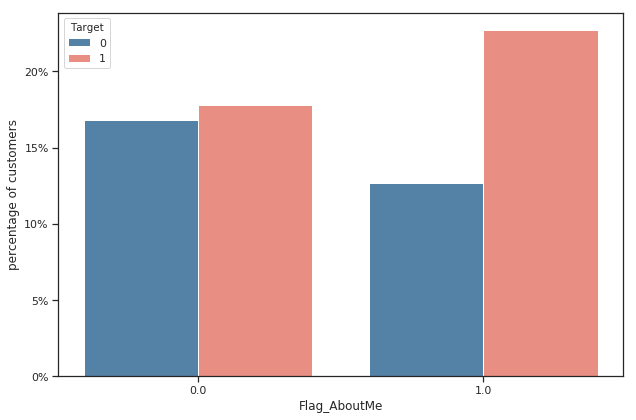

In [32]:
palette = sns.color_palette(palette = ["SteelBlue" , "Salmon"])
def barplot_percentages(feature, orient='v', axis_name="percentage of customers"):
    ratios = pd.DataFrame()
    g = df_train.groupby(feature)["Target"].value_counts().to_frame()
    g = g.rename({"Target": axis_name}, axis=1).reset_index()
    g[axis_name] = g[axis_name]/len(df)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='Target', data=g, orient=orient,palette = palette)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='Target', data=g, orient=orient,palette = palette)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()
    plt.gcf().set_size_inches(9, 6)
barplot_percentages("Flag_AboutMe")
plt.tight_layout()
plt.savefig("/home/adam/bigdata/dane/codereview/Target_Flag_AboutMe.png")

#barplot_percentages("UserContinent")

In [86]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts1 = count_vect.fit_transform(X[['body_cleaned2']])
X_train_counts1
count_vect = CountVectorizer()
X_train_counts2 = count_vect.fit_transform(X['body_cleaned2'])
X_train_counts2

<55105x115885 sparse matrix of type '<class 'numpy.int64'>'
	with 2488054 stored elements in Compressed Sparse Row format>

In [94]:
y_test.values.shape

(38573, 1)

In [123]:
y_test.value_counts()

1    9561
0    6971
Name: Target, dtype: int64

In [124]:
set(y_test) - set(y_pred)

{0}

In [125]:
y_test


47283    1
18351    0
45303    0
4201     0
28672    0
22692    1
3073     0
39332    1
48939    1
20867    1
25634    0
54426    1
25497    0
50504    0
50637    1
16603    0
4590     1
32779    1
7333     0
5008     1
6910     1
30647    1
41008    1
49450    0
5730     1
2417     1
40891    1
2766     0
47240    0
8834     0
        ..
31545    1
13045    1
25289    1
43754    1
24077    1
27069    0
34935    0
26537    0
551      0
51728    1
35254    1
36267    0
19450    1
1826     1
2313     1
10908    0
38467    1
32121    0
26171    1
43616    1
10848    1
12153    0
42264    1
33732    1
13791    1
32574    1
527      1
15713    1
30301    1
52825    0
Name: Target, Length: 16532, dtype: int32

In [34]:
import matplotlib.pyplot as plt
num_cols = df.columns[(df.dtypes == 'float64')| (df.dtypes == 'int64') | (df.dtypes == 'int32')].tolist()
num_cols
#object_cols = df.columns[df.dtypes == 'object'].tolist()
#object_cols


df_train[num_cols].dropna(subset=['Target']).corr().loc[:,'Target'].sort_values(ascending=False)
df_train[num_cols].dropna(subset=['Target']).corr().loc[:,'Target'].sort_values(ascending=False).reindex( df_train[num_cols].dropna(subset=['Target']).corr().loc[:,'Target'].abs().sort_values(ascending=False).index)
df_corr = df_train[num_cols].dropna(subset=['Target']).corr().loc[:,'Target'].sort_values(ascending=False).reindex( df_train[num_cols].dropna(subset=['Target']).corr().loc[:,'Target'].abs().sort_values(ascending=False).index)

#df_corr.to_excel('/home/adam/bigdata/dane/codereview/corr.xlsx')

Target                                  1.000000
Flag_AboutMe                            0.129935
pct_class3                              0.099194
Id                                     -0.099191
Flag_Location                           0.095415
Flag_WebsiteUrl                         0.090317
Reputation                              0.080515
class3                                  0.076822
Flag_Time_from_last_question_missing   -0.066033
no_signs_body                          -0.057020
class2                                  0.055035
no_words_body                          -0.053784
class1                                  0.053291
Up                                      0.051996
pct_class2                              0.050375
word_count_body                        -0.045897
OwnerUserId_Null                        0.041648
No_of_answers                           0.040568
BountyS                                 0.039370
No_of_comments                          0.038501
Fav                 

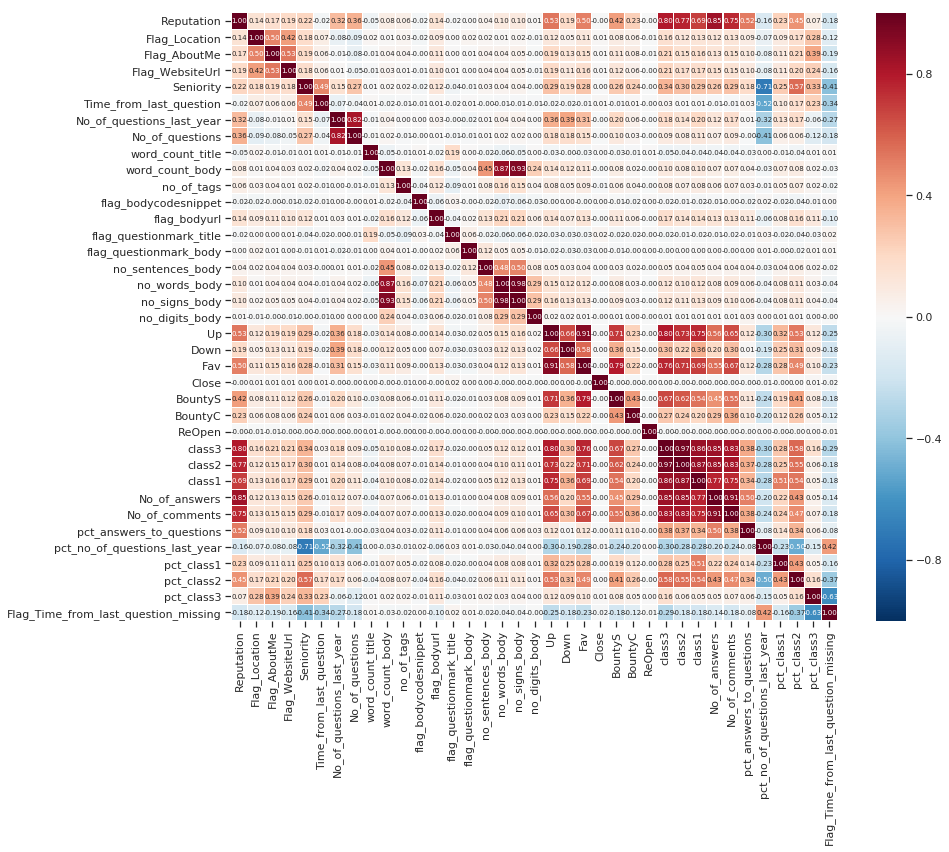

In [25]:
num_cols = df.columns[(df.dtypes == 'float64')| (df.dtypes == 'int64') | (df.dtypes == 'int32')].tolist()
num_cols
corr = df_train[num_cols].drop(['Target','Id','OwnerUserId_Null'], axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(14, 12))

sns.heatmap(corr, 
            cmap="RdBu_r", vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 7},fmt=".2f");
plt.tight_layout()
plt.savefig("/home/adam/bigdata/dane/codereview/Correlation.png")

In [36]:
# print(pd.crosstab(df_train.language,df_train.Target, normalize='index',margins=True))
# print(pd.crosstab(df_train.UserContinent,df_train.Target, normalize='index',margins=True,dropna = True))
# z = pd.crosstab(df_train.UserCountry,df_train.UserContinent, normalize='index',margins=True)
# print(z[60:120])
# print(df_train['UserCountry'].value_counts()[120:180])
print(pd.concat([pd.crosstab(df_train.UserContinent.replace(np.nan, 'missing'),df_train.Target.replace(np.nan, 'missing'),normalize = 'index',margins=True,dropna=False),
pd.crosstab(df_train.UserContinent.replace(np.nan, 'missing'),df_train.Target.replace(np.nan, 'missing'),margins=True,dropna=False)],axis=1))
print(pd.concat([pd.crosstab(df_train.language.replace(np.nan, 'missing'),df_train.Target.replace(np.nan, 'missing'),normalize = 'index',margins=True,dropna=False),
pd.crosstab(df_train.language.replace(np.nan, 'missing'),df_train.Target.replace(np.nan, 'missing'),margins=True,dropna=False)],axis=1))

df_cross_continent = pd.concat([pd.crosstab(df_train.UserContinent.replace(np.nan, 'missing'),df_train.Target.replace(np.nan, 'missing'),normalize = 'index',margins=True,dropna=False),
pd.crosstab(df_train.UserContinent.replace(np.nan, 'missing'),df_train.Target.replace(np.nan, 'missing'),margins=True,dropna=False)],axis=1)
df_cross_language = pd.concat([pd.crosstab(df_train.language.replace(np.nan, 'missing'),df_train.Target.replace(np.nan, 'missing'),normalize = 'index',margins=True,dropna=False),
pd.crosstab(df_train.language.replace(np.nan, 'missing'),df_train.Target.replace(np.nan, 'missing'),margins=True,dropna=False)],axis=1)

df_cross_continent.to_excel('/home/adam/bigdata/dane/codereview/cross_continent.xlsx')
df_cross_language.to_excel('/home/adam/bigdata/dane/codereview/cross_language.xlsx')

Target                0         1      0      1    All
UserContinent                                         
AF             0.400000  0.600000    108    162    270
AS             0.407618  0.592382   1145   1664   2809
Brak           0.468252  0.531748   8960  10175  19135
EU             0.373403  0.626597   2718   4561   7279
NA             0.358112  0.641888   2375   4257   6632
OC             0.405498  0.594502    236    346    582
SA             0.366516  0.633484    162    280    442
missing        0.394663  0.605337    562    862   1424
All            0.421694  0.578306  16266  22307  38573
Target             0         1      0      1    All
language                                           
R           0.479452  0.520548    105    114    219
c           0.360704  0.639296    615   1090   1705
c#          0.388776  0.611224   2113   3322   5435
c++         0.419377  0.580623   1870   2589   4459
delphi      0.666667  0.333333     34     17     51
f#          0.417476  0.582524 